In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Step 6: Forecast Next Year for a Country (Scaled + Real Values)

In [2]:
# Load dataset
df = pd.read_csv("global_inflation_data.csv")

# Drop useless column
df.drop("indicator_name", axis=1, inplace=True)

# Check structure
print(df.head())
print(df.info())

# Identify numeric columns (all years)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values with column mean (per year)
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

# Scale values (mean=0, std=1) for ML
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


  country_name  1980  1981  1982  1983  1984  1985  1986  1987  1988  ...  \
0  Afghanistan  13.4  22.2  18.2  15.9  20.4   8.7  -2.1  18.4  27.5  ...   
1      Albania   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2      Algeria   9.7  14.6   6.6   7.8   6.3  10.4  14.0   5.9   5.9  ...   
3      Andorra   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4       Angola  46.7   1.4   1.8   1.8   1.8   1.8   1.8   1.8   1.8  ...   

   2015   2016   2017   2018  2019   2020   2021   2022  2023  2024  
0 -0.66   4.38   4.98   0.63   2.3   5.44   5.06  13.71   9.1   NaN  
1  1.90   1.30   2.00   2.00   1.4   1.60   2.00   6.70   4.8   4.0  
2  4.80   6.40   5.60   4.30   2.0   2.40   7.20   9.30   9.0   6.8  
3 -1.10  -0.40   2.60   1.00   0.5   0.10   1.70   6.20   5.2   3.5  
4  9.20  30.70  29.80  19.60  17.1  22.30  25.80  21.40  13.1  22.3  

[5 rows x 46 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 46

### Step 3: Exploratory Data Analysis (EDA)

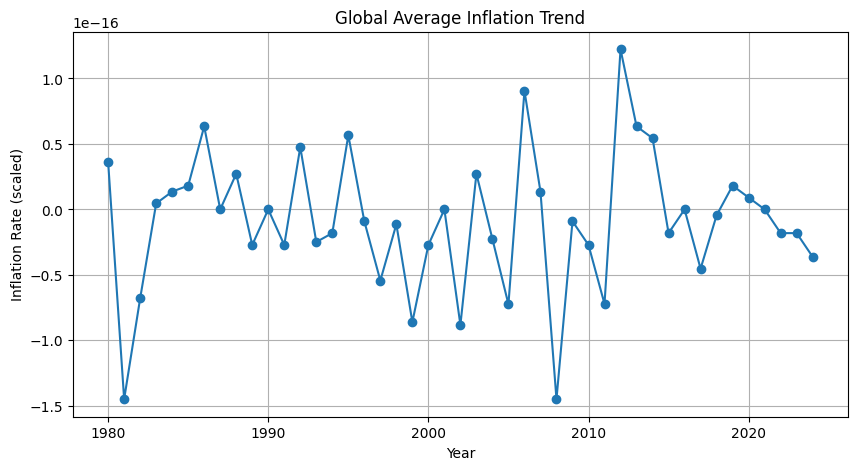

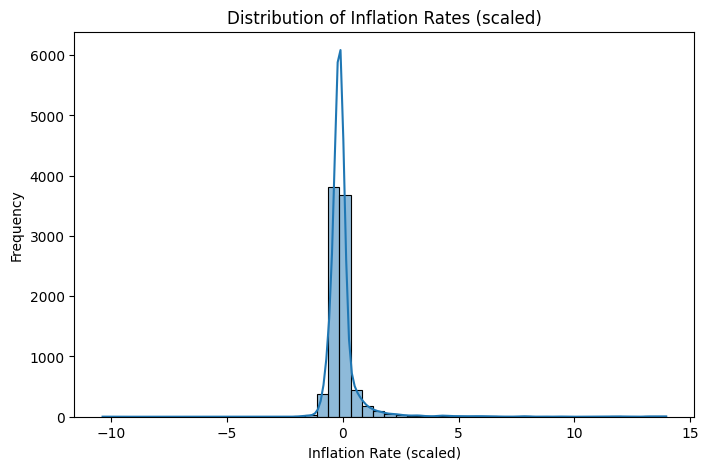

In [3]:
# Global average inflation trend
global_avg = df[num_cols].mean().reset_index()
global_avg.columns = ["year", "avg_inflation"]
global_avg["year"] = global_avg["year"].astype(int)

plt.figure(figsize=(10,5))
plt.plot(global_avg["year"], global_avg["avg_inflation"], marker="o")
plt.title("Global Average Inflation Trend")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (scaled)")
plt.grid(True)
plt.show()

# Distribution of inflation across all countries & years
plt.figure(figsize=(8,5))
sns.histplot(df[num_cols].values.flatten(), bins=50, kde=True)
plt.title("Distribution of Inflation Rates (scaled)")
plt.xlabel("Inflation Rate (scaled)")
plt.ylabel("Frequency")
plt.show()

### Step 4: Reshape Data & Feature Engineering

In [4]:
# Melt wide format → long format (country, year, inflation)
df_long = df.melt(id_vars=["country_name"], 
                  var_name="year", 
                  value_name="inflation_rate")

# Convert year to numeric
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")

# Sort values for time-series operations
df_long = df_long.sort_values(["country_name", "year"])

# Create lag features (inflation from last 1 & 2 years)
df_long["lag1"] = df_long.groupby("country_name")["inflation_rate"].shift(1)
df_long["lag2"] = df_long.groupby("country_name")["inflation_rate"].shift(2)

# Drop rows missing lag values
df_model = df_long.dropna(subset=["lag1", "lag2"])

### Step 5: Train-Test Split & Model Training

MAE: 0.378423932076016
RMSE: 1.1381806491638218


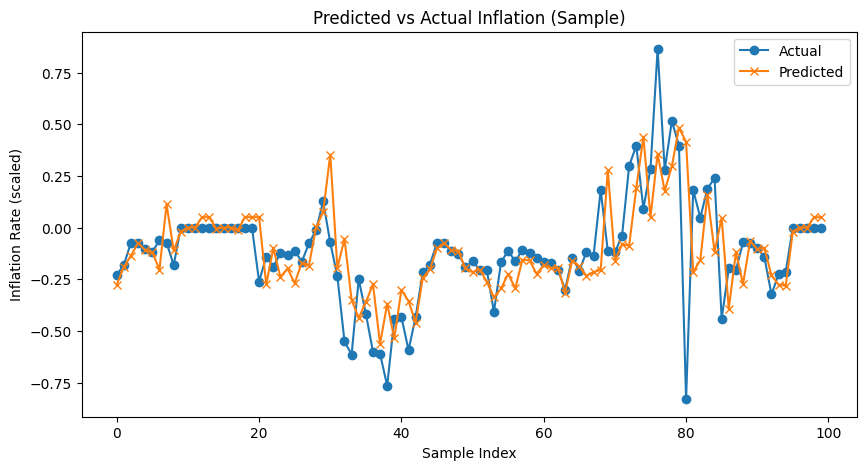

In [5]:
# Features (X) and Target (y)
X = df_model[["lag1", "lag2"]]
y = df_model["inflation_rate"]

# Split into train/test (keep time order, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("MAE:", mae)
print("RMSE:", rmse)

# Plot predicted vs actual (sample of 100 points)
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label="Actual", marker="o")
plt.plot(y_pred[:100], label="Predicted", marker="x")
plt.title("Predicted vs Actual Inflation (Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Inflation Rate (scaled)")
plt.legend()
plt.show()

### Step 6: Forecast Next Year for a Country

c:\Users\Ayush\Desktop\Inflation Rate\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted inflation for India in 2025:
  • Scaled value : -0.18
  • Real value   : 4.85%


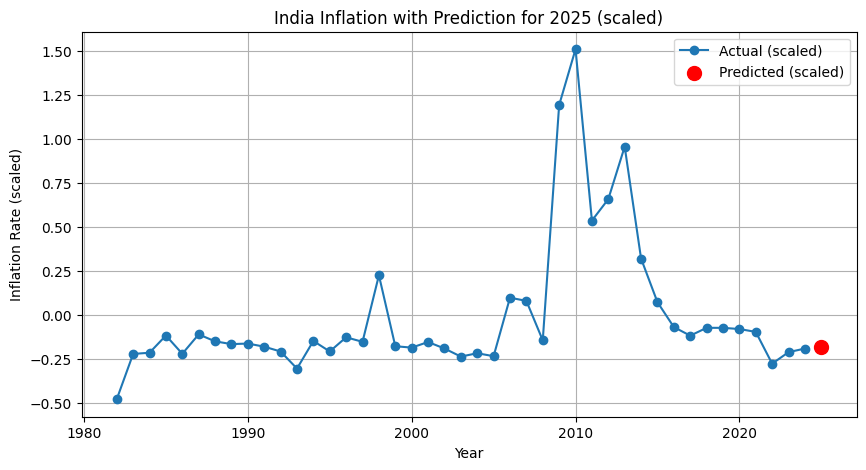

In [ ]:
country = "India"   # <- change to any country

# Extract that country’s history
country_data = df_long[df_long["country_name"] == country].dropna()

# Get the last 2 records
last_two = country_data.tail(2)

if len(last_two) < 2:
    print(f"Not enough data to predict for {country}")
else:
    # Last known year & values
    last_year = last_two["year"].iloc[-1]
    last_lag1 = last_two["inflation_rate"].iloc[-1]
    last_lag2 = last_two["inflation_rate"].iloc[-2]

    # Predict (still scaled value)
    next_year = last_year + 1
    next_inflation_scaled = model.predict([[last_lag1, last_lag2]])[0]

    
    # Inverse transform to get real %
    
    # Reconstruct a "fake row" to inverse transform
    # (we put 0s for other years, only replace the last year column with the prediction)
    fake_row = np.zeros(len(num_cols))
    fake_row[-1] = next_inflation_scaled
    pred_original = scaler.inverse_transform([fake_row])[0]

    # The "last column" corresponds to the most recent year in num_cols
    pred_inflation_real = pred_original[-1]

    print(f"Predicted inflation for {country} in {next_year}:")
    print(f"  • Scaled value : {next_inflation_scaled:.2f}")
    print(f"  • Real value   : {pred_inflation_real:.2f}%")

    
    # Plot
   
    plt.figure(figsize=(10,5))
    plt.plot(country_data["year"], country_data["inflation_rate"], marker="o", label="Actual (scaled)")
    plt.scatter(next_year, next_inflation_scaled, color="red", s=100, label="Predicted (scaled)")
    plt.title(f"{country} Inflation with Prediction for {next_year} (scaled)")
    plt.xlabel("Year")
    plt.ylabel("Inflation Rate (scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()
